In [1]:
import pandas as pd
import openpyxl
import os
import urllib
import datetime
from db_utils.base import Session, Session_ax
import matplotlib.pyplot as plt
import seaborn as sns
from extract_info import get_armoires_etuves, GetPrice, moteur2demarrer, var2art, map_moteur

In [2]:
def plot_concentric_bubbles(data, x, y, size, hue, max_hue=10):
    """
    Plots a bubble chart with concentric circles.

    Parameters:
    data (pd.DataFrame): The DataFrame containing the data.
    x (str): The column name for x-axis values.
    y (str): The column name for y-axis values.
    size (str): The column name for the size of the bubbles.
    hue (str): The column name for the hue of the bubbles.
    """
    # Sort data by hue
    import matplotlib

# Find hues and sort from most to least frequent
    hue_size = data.groupby(hue, as_index=False)[size].sum()
    hue_size = hue_size.sort_values(by=size, ascending=False)
    hue_order = hue_size[hue].values
    # map hue to integer
    hue2int = {hue: i for i, hue in enumerate(hue_order)}
    data['hue_int'] = data[hue].map(hue2int)
    data_sorted = data.sort_values(by='hue_int')

    #  Remove hues with low frequency
    if len(hue_order) > max_hue:
        hue_order = hue_order[:max_hue]
        data_sorted = data_sorted[data_sorted[hue].isin(hue_order)]
        data_sorted['hue_int'] = data_sorted[hue].map(hue2int)

    # Prepare figure
    fig, ax = plt.subplots(1, 1, figsize=(9, 6))

    #  Choose a color palette pastel
    colors = matplotlib.colormaps.get_cmap('Pastel2').colors

    # Iterate over each hue
    for hue_int in range(len(hue_order)):
        hue_value = hue_order[hue_int]
        hue_data = data_sorted[data_sorted['hue_int'] >= hue_int]

        # Cumulative sum for size within each (x, y) group
        to_plot = hue_data.groupby([x, y], as_index=False)[size].sum()
        # Modify size for best plot effect
        to_plot[size] = to_plot[size].apply(lambda x: 100*x**(1))
        # Scatter plot for each hue. linewidth is 0 to remove the line between points
        ax.scatter(to_plot[x], to_plot[y], s=to_plot[size], alpha=1, label=hue_value, linewidth=0, zorder=hue_int, color=colors[hue_int])


    # Calculate total sum of size for each (x, y) group and add as text
    totals = data.groupby([x, y], as_index=False)[size].sum()
    for i, txt in enumerate(totals[size]):
        ax.text(totals[x].iloc[i], totals[y].iloc[i], txt, ha='center', va='center', color='black', zorder=len(hue_order)+1)

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    # Customize and place legend outside the plot
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # Make all legend markers the same size
    for handle in legend.legend_handles:
        handle.set_sizes([100])
    return fig, ax

In [3]:
df_etuve = get_armoires_etuves(cache=False)

print(df_etuve.head())

      Num_AF Lettrage         Client       Date Tension_Freq Neutre   Type  \
28  AF003800        B     ASSA ABLOY 2020-09-17  3x230V 50Hz   SANS  ETUVE   
34  AF003773        C       TEC CHIM 2020-08-31  3x400V 50Hz     TT  ETUVE   
41  AF003726        A  BELLOPRATRAIN 2020-07-24  3x400V 50Hz   SANS  ETUVE   
47  AF003678        C           AEIB 2020-07-16  3x400V 50Hz   SANS  ETUVE   
49  AF003678        F           AEIB 2020-07-16  3x400V 50Hz   SANS  ETUVE   

                                               Caract  \
28  ETUVE:  NBR MS=2  MS1= 4kW  MS2=4kW      NBR M...   
34  ETUVE:  NBR MS=1  MS1= 5,5kW        NBR ME=1  ...   
41  ETUVE:  NBR MS=4  MS1= 4kW  MS2=kW  MS3=kW  MS...   
47  ETUVE:  NBR MS=2  MS1= 1,5kW  MS2=1,5kW      N...   
49  ETUVE:  NBR MS=2  MS1= 4kW  MS2=4kW      NBR M...   

                                               Specif    Num_Schemas  ...  \
28  Marche cycle par cycle, dernier cycle ou cycle...  E:201-R18-BVG  ...   
34   Marche cycle par cycle, derni

In [4]:
# On garde uniquememnt les étuves réconnues en tant que telles sur Divalto

df_etuve = df_etuve[df_etuve['type_equip_divalto'] == 'ETUVE']

In [5]:
# On essaye de filtrer les monoblocs:
 # Chauffage electrique
 # 1 seul groupe de soufflage
 # Pas de "modul" dans la desscription
monobloc = df_etuve[(df_etuve['Chauff'].str.lower().str.strip() == 'résist élec') & (df_etuve['Nb_MS'] == 1)]
monobloc = monobloc[~monobloc['description_divalto'].str.lower().str.contains('modul')]

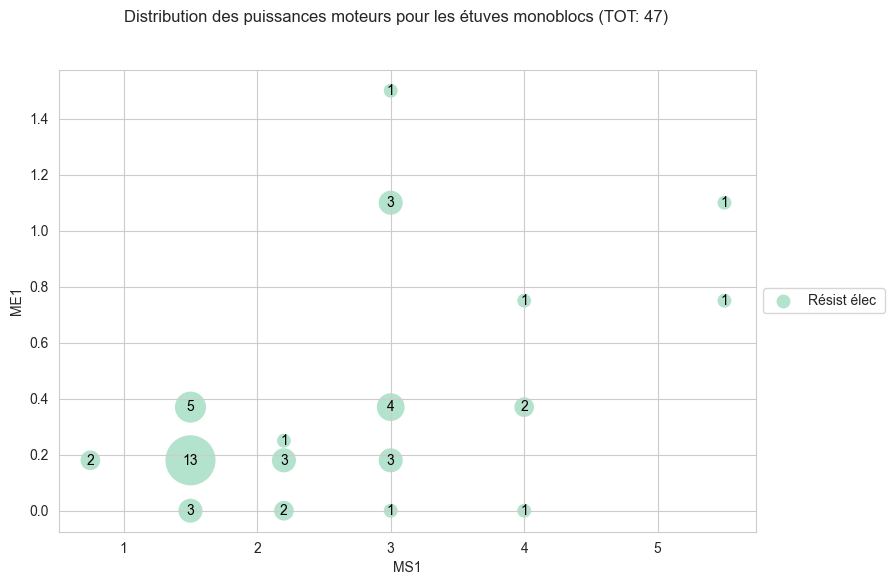

In [6]:
# Replace no ME1 by 0
monobloc['ME1'] = monobloc['ME1'].fillna(0)
distinct_cases = monobloc.groupby(['MS1', 'ME1', 'Chauff'], as_index=False)['Num_AF'].count()

fig, ax = plot_concentric_bubbles(distinct_cases, 'MS1', 'ME1', 'Num_AF', 'Chauff')
tot_mono = sum(distinct_cases['Num_AF'])
fig.suptitle(f'Distribution des puissances moteurs pour les étuves monoblocs (TOT: {tot_mono})')
plt.show()


In [7]:
# Maintenant on prend les étuves modulaires

# Prend toutes les étves qui ne sont pas dans "monobloc"
modul = df_etuve[~df_etuve['Num_AF'].isin(monobloc['Num_AF'])]
# On elimine ces qui ont "monobloc" dans la description
modul = modul[~modul['description_divalto'].str.lower().str.contains('monobloc')]

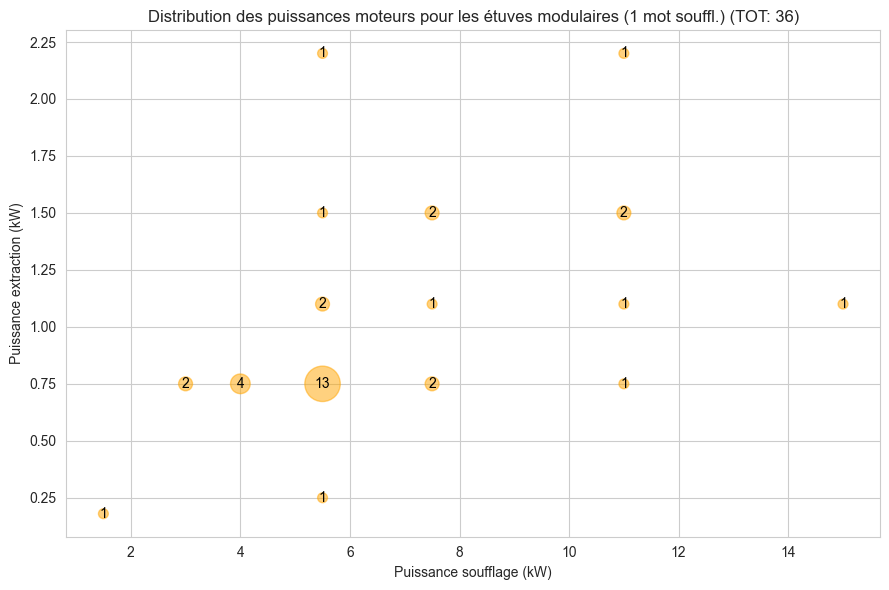

In [8]:
# Replace no ME1 by 0
modul['ME1'] = modul['ME1'].fillna(0)
# 1 seul moteur de soufflage
df = modul[modul['Nb_MS'] == 1]


distinct_cases = df.groupby(['MS1', 'ME1'], as_index=False)['Num_AF'].count()
# Add number of armoires as text on each bubble
distinct_cases['text'] = distinct_cases['Num_AF'].apply(lambda x: str(x))

#  Plot
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
ax.scatter(distinct_cases['MS1'], distinct_cases['ME1'], s=distinct_cases['Num_AF']*50, color='orange', alpha=0.5)
# Add text
for i, txt in enumerate(distinct_cases['text']):
    # ax.annotate(txt, (distinct_cases['MS1'].iloc[i], distinct_cases['ME1'].iloc[i]))
    # Center text horizontally and vertically. Color is red
    ax.text(distinct_cases['MS1'].iloc[i], distinct_cases['ME1'].iloc[i], txt, ha='center', va='center', color='black')

plt.xlabel('Puissance soufflage (kW)')
plt.ylabel('Puissance extraction (kW)')
tot_mono = sum(distinct_cases['Num_AF'])
plt.title(f'Distribution des puissances moteurs pour les étuves modulaires (1 mot souffl.) (TOT: {tot_mono})')
plt.tight_layout()
plt.show()


In [9]:
df

,Num_AF,Lettrage,Client,Date,Tension_Freq,Neutre,Type,Caract,Specif,Num_Schemas,...,ME2_motor_price,ME3_motor_price,ME4_motor_price,code_armoire,armoire_price,tot_price_MS,tot_price_ME,tot_price_demarr,tot_price_var,tot_price_material
34,AF003773,C,TEC CHIM,2020-08-31,3x400V 50Hz,TT,ETUVE,"ETUVE: NBR MS=1 MS1= 5,5kW NBR ME=1 ...","Marche cycle par cycle, dernier cycle ou cycl...",E:101-R08-BVG,...,0.0,0,0,AF003773CV1,1590.82,315.12,132.51,0.00,0.00,447.63
82,AF003285,D,ASCO,2020-04-03,3x400V 50Hz,TNS,ETUVE,"ETUVE: NBR MS=1 MS1= 5,5kW NBR ME=1 ...","Ecl. Spot LED: 2x30w, Bruleur Modulant BS3/M,...",E:101-R08-BVG,...,0.0,0,0,AF003285DV1,4244.39,315.12,98.59,0.00,0.00,413.71
102,AF003270,J,JEANTIL,2020-02-10,3x400V 50Hz,SANS,ETUVE,"ETUVE: NBR MS=1 MS1= 7,5kW NBR ME=1 ...",Fonctionnement en continu et marche/arrêt poss...,E:501-R08-BVG,...,0.0,0,0,AF003270JV1,1455.47,335.06,113.12,113.93,113.93,676.04
111,AF003270,H,JEANTIL,2020-01-21,3x400V 50Hz,SANS,ETUVE,ETUVE: NBR MS=1 MS1= 11kW NBR ME=1 M...,Fonctionnement en continu et marche/arrêt poss...,E:501-R08-BVG,...,0.0,0,0,AF003270HV1,1419.12,609.49,165.64,132.51,132.51,1040.15
112,AF003270,F,JEANTIL,2020-01-21,3x400V 50Hz,SANS,ETUVE,"ETUVE: NBR MS=1 MS1= 5,5kW NBR ME=1 ...",Fonctionnement en continu et marche/arrêt poss...,E:101-R18-BVG,...,0.0,0,0,AF003270FV1,1219.46,315.12,98.59,0.00,0.00,413.71
163,AF003240,C,FIN'TECH INDUSTRIE,2019-07-19,3x400V 50Hz,TT,ETUVE,"ETUVE: NBR MS=1 MS1= 5,5kW NBR ME=1 ...","Marche cycle par cycle, dernier cycle ou cycle...",E:101-R08-BVG,...,0.0,0,0,AF003240CV1,1141.90,315.12,113.12,0.00,0.00,428.24
189,AF005096,C,ATELIER DE JOIGNY,2023-10-24,3x400V 50Hz,IT,ETUVE,"ETUVE: NBR MS=1 MS1= 5,5kW NBR ME=1 ...","Ecl.LED:6x75W, Préssostats(x2), BVA OMIA,",E:101-R08-BVG,...,0.0,0,0,AF005096CV1,1433.92,315.12,98.59,0.00,0.00,413.71
214,AF004798,D,FAMAT,2023-09-07,3x400V 50Hz,TNC,ETUVE,ETUVE: NBR MS=1 MS1= 4kW NBR ME=1 ME...,ETUVE 60°C\n1 automate pour l'échange d'info a...,E:505-R08-BAE,...,0.0,0,0,AF004798DV1,6030.61,244.06,98.59,0.00,0.00,342.65
219,AF004798,C,FAMAT,2023-09-07,3x400V 50Hz,TNC,ETUVE,ETUVE: NBR MS=1 MS1= 4kW NBR ME=1 ME...,ETUVE 60°C\n1 automate pour l'échange d'info a...,E:505-R08-BAE,...,0.0,0,0,AF004798CV1,6012.03,244.06,98.59,0.00,0.00,342.65
288,AF004762,C,CHEMINEES SEGUIN DUTERIEZ,2023-01-31,3x400V 50Hz,TT,ETUVE,"ETUVE: NBR MS=1 MS1= 7,5kW NBR ME=1 ...","Marche cycle par cycle, dernier cycle ou cycle...",E:501-R08-BVG,...,0.0,0,0,AF004762CV1,1338.44,335.06,98.59,113.93,113.93,661.51


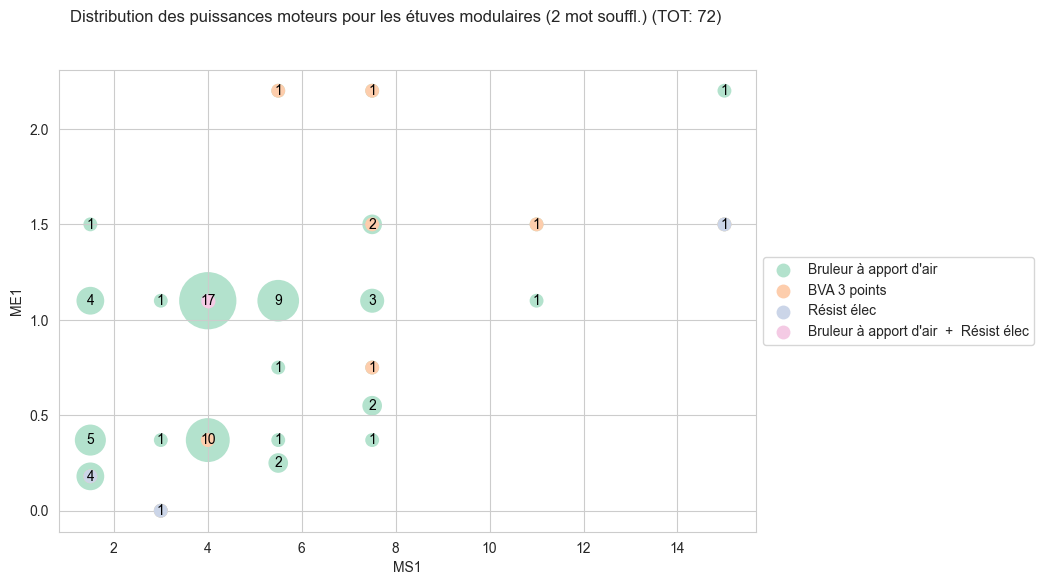

In [10]:
df = modul[modul['Nb_MS'] == 2]
# df = df[df['Chauff'].str.lower().str.strip() == 'bva 3 points']
distinct_cases = df.groupby(['MS1', 'ME1', 'Chauff'], as_index=False)['Num_AF'].count()

fig, ax = plot_concentric_bubbles(distinct_cases, 'MS1', 'ME1', 'Num_AF', 'Chauff')
tot = sum(distinct_cases['Num_AF'])
fig.suptitle(f'Distribution des puissances moteurs pour les étuves modulaires (2 mot souffl.) (TOT: {tot})')
plt.show()

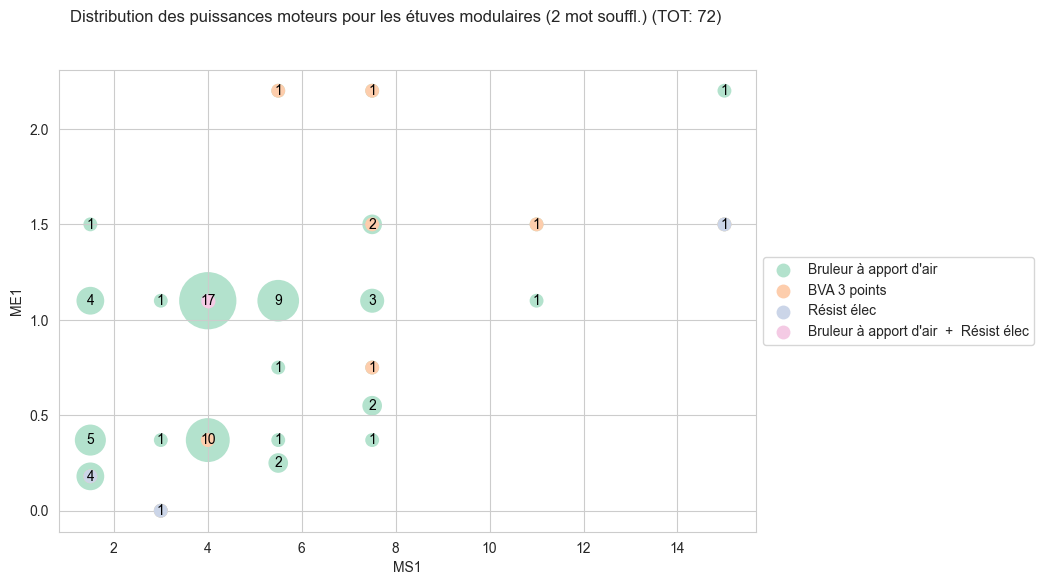

In [11]:
df = modul[modul['Nb_MS'] == 2]
# df = df[df['Chauff'].str.lower().str.strip() == 'bva 3 points']
distinct_cases = df.groupby(['MS1', 'ME1', 'Chauff'], as_index=False)['Num_AF'].count()

fig, ax = plot_concentric_bubbles(distinct_cases, 'MS1', 'ME1', 'Num_AF', 'Chauff')
tot = sum(distinct_cases['Num_AF'])
fig.suptitle(f'Distribution des puissances moteurs pour les étuves modulaires (2 mot souffl.) (TOT: {tot})')
plt.show()

In [12]:
df

,Num_AF,Lettrage,Client,Date,Tension_Freq,Neutre,Type,Caract,Specif,Num_Schemas,...,ME2_motor_price,ME3_motor_price,ME4_motor_price,code_armoire,armoire_price,tot_price_MS,tot_price_ME,tot_price_demarr,tot_price_var,tot_price_material
28,AF003800,B,ASSA ABLOY,2020-09-17,3x230V 50Hz,SANS,ETUVE,ETUVE: NBR MS=2 MS1= 4kW MS2=4kW NBR M...,"Marche cycle par cycle, dernier cycle ou cycle...",E:201-R18-BVG,...,0.0,0,0,AF003800BV1,1093.50,488.12,98.59,0.0,0.0,586.71
47,AF003678,C,AEIB,2020-07-16,3x400V 50Hz,SANS,ETUVE,"ETUVE: NBR MS=2 MS1= 1,5kW MS2=1,5kW N...","Marche cycle par cycle, dernier cycle ou cycl...",E:201-R18-BVG,...,0.0,0,0,AF003678CV1,2026.76,265.02,113.12,0.0,0.0,378.14
49,AF003678,F,AEIB,2020-07-16,3x400V 50Hz,SANS,ETUVE,ETUVE: NBR MS=2 MS1= 4kW MS2=4kW NBR M...,"Marche cycle par cycle, dernier cycle ou cycle...",E:201-R18-BVG,...,0.0,0,0,AF003678FV1,2049.06,488.12,98.59,0.0,0.0,586.71
51,AF003722,C,DOITRAND,2020-07-09,3x400V 50Hz,SANS,ETUVE,ETUVE: NBR MS=2 MS1= 4kW MS2=4kW NBR M...,"Marche cycle par cycle, dernier cycle ou cycle...",E:201-R18-BVG,...,0.0,0,0,AF003722CV1,1551.66,488.12,113.12,0.0,0.0,601.24
72,AF003650,A,QUALICOLOR,2020-05-06,3x400V 50Hz,SANS,ETUVE,"ETUVE: NBR MS=2 MS1= 5,5kW MS2=5,5kW N...","Marche cycle par cycle, dernier cycle ou cycl...",E:201-R18-BVG,...,0.0,0,0,AF003650AV1,1260.77,630.24,113.12,0.0,0.0,743.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,AF001078,D,METALBAT,2015-10-14,3x400V 50Hz,SANS,ETUVE,ETUVE: NBR MS=2 MS1= 4kW MS2=4kW NBR M...,"Marche cycle par cycle, dernier cycle ou cycle...",E:201-R18-BVG,...,0.0,0,0,AF001078DV1,1302.90,488.12,113.12,0.0,0.0,601.24
1093,AF001054,B,EFI CONCEPT,2015-09-30,3x400V 50Hz,SANS,ETUVE,"ETUVE: NBR MS=2 MS1= 1,5kW MS2=1,5kW N...","Marche cycle par cycle, dernier cycle ou cycle...",E:201-R18-BVG,...,0.0,0,0,AF001054BV1,1269.02,265.02,113.12,0.0,0.0,378.14
1123,AF000946,C,ELECTROPOLI PRODUCTION,2015-07-23,3x400V 50Hz,SANS,ETUVE,"ETUVE: NBR MS=2 MS1= 1,5kW MS2=1,5kW N...","Marche cycle par cycle, dernier cycle ou cycle...",E:201-R18-BVG,...,0.0,0,0,AF000946CV1,2839.25,265.02,98.59,0.0,0.0,363.61
1183,AF000764,B,AMP PRODUCTION,2015-02-10,3x400V 50Hz,SANS,ETUVE,ETUVE: NBR MS=2 MS1= 3kW MS2=3kW NBR M...,Marche cycle par cycle ou dernier cycle. (X3)P...,E:201-R18-BVG,...,0.0,0,0,AF000764BV1,1325.10,399.22,113.12,0.0,0.0,512.34


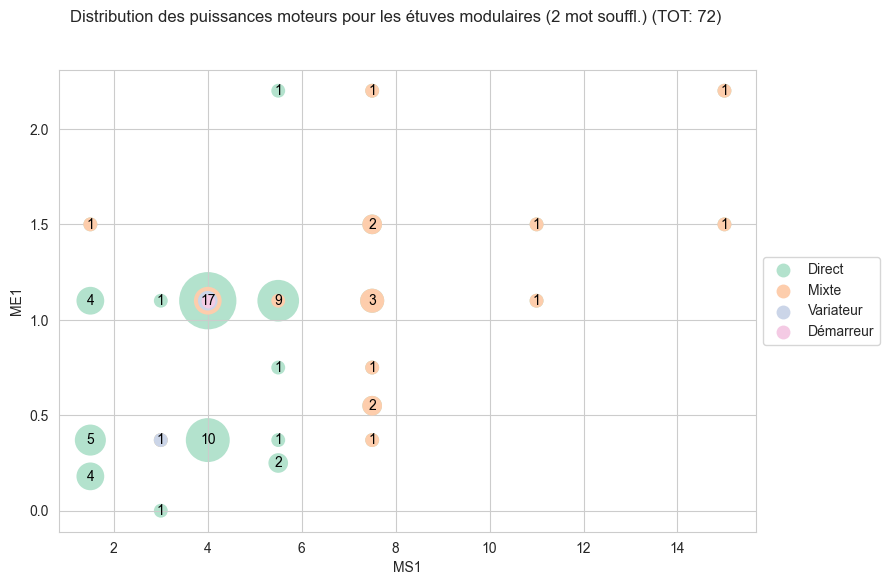

In [13]:
df = modul[modul['Nb_MS'] == 2]
# df = df[df['Chauff'].str.lower().str.strip() == 'bva 3 points']
# Apply strip on the column Regul
df.loc[:, 'Dem_Mot'] = df['Dem_Mot'].str.strip()
distinct_cases = df.groupby(['MS1', 'ME1', 'Dem_Mot'], as_index=False)['Num_AF'].count()

fig, ax = plot_concentric_bubbles(distinct_cases, 'MS1', 'ME1', 'Num_AF', 'Dem_Mot', max_hue=10)
tot = sum(distinct_cases['Num_AF'])
fig.suptitle(f'Distribution des puissances moteurs pour les étuves modulaires (2 mot souffl.) (TOT: {tot})')
plt.show()

In [14]:
df
# 3 Population
# 1. Monobloc
# 2. Modulaire 1 moteur soufflage
# 3. Modulaire 2 moteurs soufflage

# Essayer de récupérer code ADV sur AX.
#  Baasse température -> ADV-ETUVE-MOD-BT et 1 moteur
# Haute températue -> ADV-ETUVE-MOD-HT et 2 moteurs
# Monobloc -> ADV-ETUVE-MONO (on exclue par l'instant)
#  Le reste est du spécial

# Regarder si on peut récupérer la puissance /type bruleur (sous-ensemble I)

# Exclure variateurs

# Refaire l'analyse avec le prix moyen de l'armoire, vérifier l'ecart
# Trier les liste avec Julien G. pour vérifier

# Faire tourner avec 1,2,3 standards sur les 3 populations



# Exclure AF004086-A

,Num_AF,Lettrage,Client,Date,Tension_Freq,Neutre,Type,Caract,Specif,Num_Schemas,...,ME2_motor_price,ME3_motor_price,ME4_motor_price,code_armoire,armoire_price,tot_price_MS,tot_price_ME,tot_price_demarr,tot_price_var,tot_price_material
28,AF003800,B,ASSA ABLOY,2020-09-17,3x230V 50Hz,SANS,ETUVE,ETUVE: NBR MS=2 MS1= 4kW MS2=4kW NBR M...,"Marche cycle par cycle, dernier cycle ou cycle...",E:201-R18-BVG,...,0.0,0,0,AF003800BV1,1093.50,488.12,98.59,0.0,0.0,586.71
47,AF003678,C,AEIB,2020-07-16,3x400V 50Hz,SANS,ETUVE,"ETUVE: NBR MS=2 MS1= 1,5kW MS2=1,5kW N...","Marche cycle par cycle, dernier cycle ou cycl...",E:201-R18-BVG,...,0.0,0,0,AF003678CV1,2026.76,265.02,113.12,0.0,0.0,378.14
49,AF003678,F,AEIB,2020-07-16,3x400V 50Hz,SANS,ETUVE,ETUVE: NBR MS=2 MS1= 4kW MS2=4kW NBR M...,"Marche cycle par cycle, dernier cycle ou cycle...",E:201-R18-BVG,...,0.0,0,0,AF003678FV1,2049.06,488.12,98.59,0.0,0.0,586.71
51,AF003722,C,DOITRAND,2020-07-09,3x400V 50Hz,SANS,ETUVE,ETUVE: NBR MS=2 MS1= 4kW MS2=4kW NBR M...,"Marche cycle par cycle, dernier cycle ou cycle...",E:201-R18-BVG,...,0.0,0,0,AF003722CV1,1551.66,488.12,113.12,0.0,0.0,601.24
72,AF003650,A,QUALICOLOR,2020-05-06,3x400V 50Hz,SANS,ETUVE,"ETUVE: NBR MS=2 MS1= 5,5kW MS2=5,5kW N...","Marche cycle par cycle, dernier cycle ou cycl...",E:201-R18-BVG,...,0.0,0,0,AF003650AV1,1260.77,630.24,113.12,0.0,0.0,743.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1079,AF001078,D,METALBAT,2015-10-14,3x400V 50Hz,SANS,ETUVE,ETUVE: NBR MS=2 MS1= 4kW MS2=4kW NBR M...,"Marche cycle par cycle, dernier cycle ou cycle...",E:201-R18-BVG,...,0.0,0,0,AF001078DV1,1302.90,488.12,113.12,0.0,0.0,601.24
1093,AF001054,B,EFI CONCEPT,2015-09-30,3x400V 50Hz,SANS,ETUVE,"ETUVE: NBR MS=2 MS1= 1,5kW MS2=1,5kW N...","Marche cycle par cycle, dernier cycle ou cycle...",E:201-R18-BVG,...,0.0,0,0,AF001054BV1,1269.02,265.02,113.12,0.0,0.0,378.14
1123,AF000946,C,ELECTROPOLI PRODUCTION,2015-07-23,3x400V 50Hz,SANS,ETUVE,"ETUVE: NBR MS=2 MS1= 1,5kW MS2=1,5kW N...","Marche cycle par cycle, dernier cycle ou cycle...",E:201-R18-BVG,...,0.0,0,0,AF000946CV1,2839.25,265.02,98.59,0.0,0.0,363.61
1183,AF000764,B,AMP PRODUCTION,2015-02-10,3x400V 50Hz,SANS,ETUVE,ETUVE: NBR MS=2 MS1= 3kW MS2=3kW NBR M...,Marche cycle par cycle ou dernier cycle. (X3)P...,E:201-R18-BVG,...,0.0,0,0,AF000764BV1,1325.10,399.22,113.12,0.0,0.0,512.34


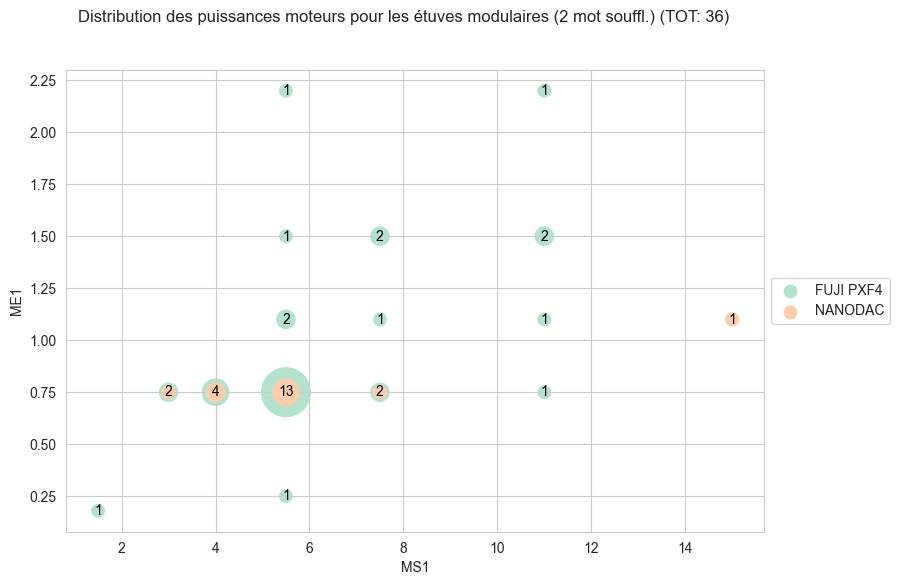

In [15]:
df = modul[modul['Nb_MS'] == 1]
# df = df[df['Chauff'].str.lower().str.strip() == 'bva 3 points']
# Apply strip on the column Regul
df.loc[:, 'Regul'] = df['Regul'].str.strip()
distinct_cases = df.groupby(['MS1', 'ME1', 'Regul'], as_index=False)['Num_AF'].count()

fig, ax = plot_concentric_bubbles(distinct_cases, 'MS1', 'ME1', 'Num_AF', 'Regul')
tot = sum(distinct_cases['Num_AF'])
fig.suptitle(f'Distribution des puissances moteurs pour les étuves modulaires (2 mot souffl.) (TOT: {tot})')
plt.show()

In [23]:
from spec_equipement import build_tree, convert_tree_to_json_list_info
import json

project_code = 'AF003650-A'
df, tree =build_tree(project_code)
ADV = df[df['code_article'].str.contains('ADV')]['code_article'].values[0]
ADV

json_tree = convert_tree_to_json_list_info(tree)
# Dumps as file
with open(f'./temp/{project_code}_aslistinfo.json', 'w') as f:
    f.write(json.dumps(json_tree, indent=4))

2023-12-21 18:29:54 spec_equipement p.menegatti      DEBUG    Fetching data for project AF003650-A
2023-12-21 18:29:55 spec_equipement p.menegatti      DEBUG    Fetched 576 rows. Building tree
2023-12-21 18:29:55 spec_equipement p.menegatti      DEBUG    Tree built. Extracting features
